<a href="https://colab.research.google.com/github/quarmedmund/Average-Treatment-Effect-Primer-Quarm/blob/main/Average_Treatment_Effect_Primer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An Introduction to Average Treatment Effect in Causal Analysis. Content follows.

1. Use of synthetic based data set to model code for
  - perfect based and distance based mathing
  - ATE with IPTW (Inverse Probability Treatment Weighting) using different formulas for weights. ( Lunceford, J.K. and Davidian, M., 2004. Stratification and weighting via the propensity score in estimation of causal treatment effects: a comparative study.)
  - ATE with Real time dataset (Provided in the repo)



In [15]:
import pandas as pd
import numpy as np

from typing import List, Set, Tuple

def prepend_print(df):
    s = str(df)
    lines = s.splitlines()
    print("# "+"\n# ".join(lines))

In [1]:
# synthetic dataset
example_l = [
    [71, "A", 0, 0, 84, 0.09],
    [22, "A", 0, 0, 35, 0.96],
    [35, "C", 0, 0, 64, 0.76],
    [46, "D", 1, 0, 76, 0.35],
    [55, "A", 1, 0, 45, 0.21],
    [61, "B", 1, 0, 60, 0.32],
    [73, "D", 0, 0, 77, 0.12],
    [43, "D", 0, 0, 55, 0.60],
    [67, "B", 0, 0, 101, 0.04],
    [58, "C", 1, 0, 95, 0.25],
    [59, "C", 0, 0, 87, 0.18],
    [30, "C", 1, 0, 40, 0.71],
    [62, "B", 0, 1, 65, 0.34],
    [43, "D", 0, 1, 60, 0.60],
    [24, "D", 0, 1, 40, 0.95],
    [55, "A", 1, 1, 47, 0.21],
    [30, "C", 1, 1, 42, 0.71],
    [21, "C", 1, 1, 35, 0.96],
    [20, "C", 1, 1, 35, 0.96],
    [20, "C", 1, 1, 35, 0.96]
]

In [4]:
df = pd.DataFrame.from_records(example_l, columns = ["Age", "Ethnicity", "BachelorsDegree", "T", "Y", "Propensity"])
df.dtypes
df1 = df

In [ ]:
df

,Age,Ethnicity,BachelorsDegree,T,Y,Propensity
0,71,A,0,0,84,0.09
1,22,A,0,0,35,0.96
2,35,C,0,0,64,0.76
3,46,D,1,0,76,0.35
4,55,A,1,0,45,0.21
5,61,B,1,0,60,0.32
6,73,D,0,0,77,0.12
7,43,D,0,0,55,0.60
8,67,B,0,0,101,0.04
9,58,C,1,0,95,0.25


##  Perfect matchings

A function `perfect_matchings` that, for a dataframe, returns a list of perfect matchings.

The first entry of returned tuples is the one corresponding to the treatment column having value 1.

In [5]:
def perfect_matchings(df : pd.DataFrame, columns : List[str], treatment_col) -> Set[Tuple[int, int]]:
    treated = df[df[treatment_col] == 1]
    untreated = df[df[treatment_col] == 0]

    indexes = []

    for i, row in treated.iterrows():
        matching_rows = untreated[(untreated[columns] == row[columns]).all(1)]

        if len(matching_rows)> 0:
            idx_treated = i
            idx_untreated = matching_rows.index[0]
            indexes.append((idx_treated, idx_untreated))
    return set(indexes)

In [7]:
perfect_matchings(df, ["Age", "Ethnicity", "BachelorsDegree"], "T")


{(13, 7), (15, 4), (16, 11)}

##  Distance based matchings

 A function `distance_based_matching` that, for a dataframe, returns a list of distance based matchings i.e. find for each treated individual the closest non treated individual. The Mahalanobis distance is used.


The treatment column is integer valued with values either 0 or 1. The first entry of returned tuples is the one corresponding to the treatment column having value 1.


In [8]:
def distance_based_matching(df : pd.DataFrame, columns : List[str], treatment_col : str) -> Set[Tuple[int, int]]:
    #inverse of covariance matrix
    inv_cov = np.linalg.inv(df[columns].cov())

    ##meann of the data
    mean = df[columns].mean()

    #perform matches
    matchings = []
    for i, row in df[df[treatment_col] == 1].iterrows():
        treated_row = row[columns]
        non_treated_distances = df[df[treatment_col] == 0][columns].apply(lambda non_treated_row: np.sqrt(np.dot(np.dot(non_treated_row - treated_row, inv_cov), (non_treated_row - treated_row).T)), axis=1)
        non_treated_index = non_treated_distances.sort_values().index[0]
        matchings.append((i, non_treated_index))

    return set(matchings)


In [10]:
np.random.seed(1)
n=10
d = {"v1":np.random.rand(n),
     "v2":np.random.rand(n),
     "v3":np.random.rand(n),
     "v4":np.random.rand(n),
     "T" : np.random.choice([0,1],p=[0.7, 0.3], size=n)}
df3 = pd.DataFrame.from_dict(d)

In [11]:
distance_based_matching(df3, ["v1", "v2", "v3", "v4"], "T")


{(0, 8), (1, 9), (3, 5), (6, 7)}

##  Basic ATE

A function that computes the average treatment effect given a dataframe, treatment column and value column.

In [12]:
def ATE(df, treatment_col : str, value_column : str) -> float:
    mean_treated = df[df[treatment_col] ==1][value_column].mean()
    non_treated_mean = df[df[treatment_col] == 0][value_column].mean()
    return mean_treated-non_treated_mean

##  ATE with IPTW_1

 A function `get_weights` that computes the IPTW weights $w_i = \frac{T_i}{e_i}+\frac{1-T_i}{1-e_i}$

Then a function `ATE_IPTW_1` that uses the `get_weights` function and computes the ATE using inverse probability weighting (Lunceford and Davidian, 2004)

In [13]:
#get weights function
def get_weights(df : pd.DataFrame, treatment_col : str, propensity_column : str) -> pd.Series:
    weights = df.apply(lambda row: row[treatment_col]/ row[propensity_column] + (1 - row[treatment_col]) / (1- row[propensity_column]), axis = 1)
    return pd.Series(weights, index=df.index)

In [16]:
prepend_print(get_weights(df1, "T", "Propensity"))



# 0      1.098901
# 1     25.000000
# 2      4.166667
# 3      1.538462
# 4      1.265823
# 5      1.470588
# 6      1.136364
# 7      2.500000
# 8      1.041667
# 9      1.333333
# 10     1.219512
# 11     3.448276
# 12     2.941176
# 13     1.666667
# 14     1.052632
# 15     4.761905
# 16     1.408451
# 17     1.041667
# 18     1.041667
# 19     1.041667
# dtype: float64


In [23]:
#ATE function with IPTW_1 as shown above
def ATE_IPTW_1(df : pd.DataFrame, treatment_col : str, value_column : str, propensity_column : str):
    #find the weights.
    weights_comp = get_weights(df, treatment_col, propensity_column)

    #merge into dataframe
    df = df.merge(weights_comp.rename('weights'), left_index = True, right_index = True)

    #separate into treated and non treated
    treated_n = df[df[treatment_col] == 1]
    non_treated_n = df[df[treatment_col] == 0]

    #find IPWs and sum them for treated(T==1)
    treated_n["IPW"] = treated_n[value_column] * -treated_n["weights"]
    treated_IPW_Sum = treated_n["IPW"].sum()

    #find IPWs and sum them for control(T==0)
    non_treated_n["IPW"] = non_treated_n[value_column] *-non_treated_n["weights"]
    non_treated_nIPW_sum = non_treated_n["IPW"].sum()

    #divide by n
    treated_I_1 = treated_IPW_Sum /len(df)
    non_treated_I_0 = non_treated_nIPW_sum/len(df)

    #ate
    ATE_1 = treated_I_1 - non_treated_I_0
    return ATE_1

In [24]:
prepend_print(ATE_IPTW_1(df1, "T", "Y", "Propensity"))

# 73.56885818283936


<ipython-input-23-05c698919ad3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_n["IPW"] = treated_n[value_column] * -treated_n["weights"]
<ipython-input-23-05c698919ad3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_treated_n["IPW"] = non_treated_n[value_column] *-non_treated_n["weights"]


##  ATE with IPTW_2

 A function `ATE_IPTW_2` that uses the `get_weights` function and computes the ATE using inverse probability weighting using the formula:

$$
\left(\sum_{i=1}^n T_i w_i \right)^{-1} \sum_{i=1}^n T_i w_i Y_i - \left(\sum_{i=1}^n (1-T_i) w_i \right)^{-1} \sum_{i=1}^n (1-T_i) w_i Y_i
$$

Note that this and the previous formula are asymptotically equivalent if

$$
\mathbb{E}[\frac{T}{e}]=\mathbb{E}[\frac{1-T}{1-e}]=1
$$

or similarly
$$\sum_{i=1}^nT_i w_i \approx \sum_{i=1}^n (1-T_i)w_i \approx n
$$



In [25]:
def ATE_IPTW_2(df : pd.DataFrame, treatment_col : str, value_column : str, propensity_column : str):
    #find the weights
    weights_iptw2 = get_weights(df, treatment_col, propensity_column)

    #merge into dataframe
    df = df.merge(weights_iptw2.rename('weights'), left_index=True, right_index=True)

    #compute different components of the ATE formular
    df["tw"] = df[treatment_col] * df["weights"]
    df["twy"] = df[treatment_col] * df["weights"] * df[value_column]
    df["(1-ti)wi"] = (1-df[treatment_col]) * df["weights"]
    df["(1-ti)wiyi"] = (1-df[treatment_col]) * df["weights"] * df[value_column]

    #split into treated and control
    treated_iptw2 = df[df[treatment_col] == 1]
    non_treated_iptw2 = df[df[treatment_col]== 0]

    #treated
    sum_tw = (treated_iptw2["tw"].sum()) ** -1
    sum_twy = treated_iptw2["twy"].sum()
    t_1 = sum_twy * sum_tw

    #non treated
    sum_1twi = (non_treated_iptw2["(1-ti)wi"].sum()) ** -1
    sum_1twiyi = non_treated_iptw2["(1-ti)wiyi"].sum()
    t_0 = sum_1twiyi * sum_1twi

    #ate
    ATE_2 = t_1 - t_0
    return ATE_2

In [26]:
prepend_print(ATE_IPTW_2(df1, "T", "Y", "Propensity"))
# -0.0674854905906841

# -0.0674854905906841


## f) ATE with IPTW_3 (3)

 A function `get_weights2` that computes the IPTW weights $w'_i = \frac{T_i}{e_i}(1-\frac{C_1}{e_i})+\frac{1-T_i}{1-e_i}(1-\frac{C_0}{1-e_i})$ with

$
C_1 = \sum_{i=1}^n \frac{T_i - e_i}{e_i} \left(\sum_{i=1}^n (\frac{T_i - e_i}{e_i})^2 \right)^{-1}
$

$
C_0 = - \sum_{i=1}^n \frac{T_i - e_i}{1 - e_i} \left(\sum_{i=1}^n (\frac{T_i - e_i}{1 - e_i})^2 \right)^{-1}
$

Then  a function `ATE_IPTW_3` that uses the `get_weights2` function and computes the ATE using the formula:

$$
\left(\sum_{i=1}^n T_i w'_i \right)^{-1} \sum_{i=1}^n T_i w'_i Y_i - \left(\sum_{i=1}^n (1-T_i) w'_i \right)^{-1} \sum_{i=1}^n (1-T_i) w'_i Y_i
$$





In [27]:
def get_weights2(df : pd.DataFrame, treatment_col : str, propensity_column : str) -> pd.Series:
    #break down equation into components and compute c1 and c2
    #c1
    df["ti1"] = (df[treatment_col] - df[propensity_column])/ (df[propensity_column])
    df["ti2"] = (df[treatment_col] -df[propensity_column])/ (df[propensity_column])
    df["ti2sq"] = df["ti2"] ** 2
    sum_ti1 = df["ti1"].sum()
    sum_ti2q = (df["ti2sq"].sum()) ** -1
    c_1 = sum_ti1 *sum_ti2q

    #c2
    df["ti3"] = (df[treatment_col] -df[propensity_column])/(1-df[propensity_column])
    df["t4sq"] = df["ti3"] ** 2
    sum_ti3 = -(df["ti3"].sum())
    sum_t4sq = (df["t4sq"].sum()) ** -1
    c_0 = sum_ti3 * sum_t4sq

    #calculate weights
    def compute_wi(ti, ei, c1,c0):
        wi_prime = ((ti/ei) * (1-c1/ei)) + ((1-ti)/(1-ei)) *(1-(c0/(1-ei)))
        return wi_prime

    weights_iptw3 = compute_wi(df[treatment_col], df[propensity_column], c_1,c_0)

    return pd.Series(weights_iptw3, index=df.index)


In [28]:
prepend_print(get_weights2(df1, "T", "Propensity"))

# 0     1.048399
# 1    -1.137833
# 2     3.440616
# 3     1.439478
# 4     1.198813
# 5     1.380146
# 6     1.082360
# 7     2.238622
# 8     0.996288
# 9     1.258986
# 10    1.157316
# 11    2.951004
# 12    4.369979
# 13    2.125471
# 14    1.235645
# 15    8.507246
# 16    1.736103
# 17    1.220887
# 18    1.220887
# 19    1.220887
# dtype: float64


In [29]:
def ATE_IPTW_3(df : pd.DataFrame, treatment_col : str, value_column : str, propensity_column : str):
    #find the weights
    weights_iptw3 = get_weights2(df, treatment_col, propensity_column)

    #merge into dataframe
    df = df.merge(weights_iptw3.rename('weights_iptw3'), left_index=True, right_index=True)

    #compute different components of the ATE formular
    df["tw_3"] = df[treatment_col] * df["weights_iptw3"]
    df["twy_3"] = df[treatment_col] * df["weights_iptw3"] * df[value_column]
    df["(1-ti)wi_3"] = (1-df[treatment_col]) * df["weights_iptw3"]
    df["(1-ti)wiyi_3"] = (1-df[treatment_col]) * df["weights_iptw3"] * df[value_column]

    #split into treated and control
    treated_iptw3 = df[df[treatment_col] == 1]
    non_treated_iptw3 = df[df[treatment_col]== 0]

    #treated
    sum_tw_3 = (treated_iptw3["tw_3"].sum()) ** -1
    sum_twy_3 = treated_iptw3["twy_3"].sum()
    t_1_3 = sum_twy_3 * sum_tw_3

    #non treated
    sum_1twi_3 = (non_treated_iptw3["(1-ti)wi_3"].sum()) ** -1
    sum_1twiyi_3 = non_treated_iptw3["(1-ti)wiyi_3"].sum()
    t_0_3 = sum_1twiyi_3 * sum_1twi_3

    #ate
    ATE_3 = t_1_3 - t_0_3
    return ATE_3

In [30]:
ATE_IPTW_3(df1, "T", "Y", "Propensity")


-18.939332899375806

#

I analyse a   `'learning_mindset.csv'` for the effect of the treatment. In the original learning mindset study, students were surveyed during their school years and some of the students could then participate in a course to improve their learning mindset (the treatment =`intervention`). The students were then questioned a second time years later and their success in college was measured (`achievement_score`).

This is *not* the real dataset which is highly restricted due to privacy reasons but a simulated dataset which exhibit similar effects as the original dataset.


##  Load the data and compute the baseline ATE

Load the dataset as a pandas DataFrame into `df`. Compute the `baseline_ATE` for this dataset, which is the ATE without accounting for IPTW weighting.

In [31]:
df_realtime = pd.read_csv("learning_mindset.csv")
df_realtime = df_realtime.drop(columns = "schoolid", axis = 1)

In [32]:
df_realtime.columns.tolist()

['intervention',
 'achievement_score',
 'success_expect',
 'ethnicity',
 'gender',
 'frst_in_family',
 'school_urbanicity',
 'school_mindset',
 'school_achievement',
 'school_ethnic_minority',
 'school_poverty',
 'school_size']

In [34]:
baseline_ATE = ATE(df_realtime,"intervention", "achievement_score")
print("Baseline ATE for the learning mindset is :", baseline_ATE)

Baseline ATE for the learning mindset is : 0.47227166925168707


##  Obtain propensities using linear regression

Predict the treatment column from the remaining columns using logistic regression from the statsmodels library. Properly deal with categorical variables. The trained model is named `log_model`.

Augment the dataframe `df_realtime` with a column `'propensity_score'` which contains propensity scores predicted by the logistic regression model.



In [35]:
import statsmodels.api as sm

In [36]:
propensity_col = 'propensity_score'

In [37]:
# categorical columns
cat_cols = ['ethnicity', 'gender', 'school_urbanicity', 'success_expect', 'frst_in_family']
cont_cols = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

In [38]:
data_4_predict = pd.concat([
    df_realtime.drop(columns=cat_cols), # dataset without the categorical features
    pd.get_dummies(df_realtime[cat_cols], columns=cat_cols, drop_first=False)# categorical features converted to dummies
], axis=1)


In [39]:
data_4_predict

,intervention,achievement_score,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,ethnicity_1,ethnicity_2,ethnicity_3,...,school_urbanicity_4,success_expect_1,success_expect_2,success_expect_3,success_expect_4,success_expect_5,success_expect_6,success_expect_7,frst_in_family_0,frst_in_family_1
0,1,0.277359,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,1,-0.449646,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0.769703,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,0,...,1,0,0,0,0,0,1,0,1,0
3,1,-0.121763,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,0,...,1,0,0,0,0,0,1,0,1,0
4,1,1.526147,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,0,...,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,0,0.808867,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,0,...,0,0,0,0,0,0,0,1,0,1
10387,0,-0.156063,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,0,...,0,0,0,0,0,0,0,1,0,1
10388,0,0.370820,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,0,...,0,0,1,0,0,0,0,0,0,1
10389,0,-0.396297,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [40]:
T_val = 'intervention'
Y_val = 'achievement_score'
X_val = data_4_predict.columns.drop([T_val,Y_val])

In [41]:
data_4_predict[X_val]

,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,ethnicity_1,ethnicity_2,ethnicity_3,ethnicity_4,ethnicity_5,...,school_urbanicity_4,success_expect_1,success_expect_2,success_expect_3,success_expect_4,success_expect_5,success_expect_6,success_expect_7,frst_in_family_0,frst_in_family_1
0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1
1,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
3,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
10387,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
10388,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
10389,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [42]:
# of course properly set X and y
X = data_4_predict[X_val]
y = data_4_predict[T_val]

In [43]:
# Properly set the values of y and X before fitting
log_model = sm.Logit(y, X).fit()

         Current function value: 0.626284
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
df_realtime[propensity_col] = log_model.predict(data_4_predict[X_val])
df_realtime

,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,propensity_score
0,1,0.277359,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.324382
1,1,-0.449646,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.242068
2,1,0.769703,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.352474
3,1,-0.121763,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.352474
4,1,1.526147,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.377009
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,0,0.808867,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702,0.315736
10387,0,-0.156063,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702,0.315736
10388,0,0.370820,2,15,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702,0.263787
10389,0,-0.396297,5,4,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702,0.299025


In [46]:
#check for propensity column
propensity_col in df_realtime.columns

True

In [47]:
# Compute ATE values here
weight_sums = (0, 0, 0)


ATE_1 = ATE_IPTW_1(df_realtime,"intervention", "achievement_score", "propensity_score" )
ATE_2 = ATE_IPTW_2(df_realtime,"intervention", "achievement_score", "propensity_score" )
ATE_3 = ATE_IPTW_3(df_realtime,"intervention", "achievement_score", "propensity_score" )

print("ATE's using different weights and formulas")
print("............................................")
print("ATE_1 using function ATE_IPTW_1:", ATE_1)
print("ATE_1 using function ATE_IPTW_2:", ATE_2)
print("ATE_1 using function ATE_IPTW_3:", ATE_3)

ATE's using different weights and formulas
............................................
ATE_1 using function ATE_IPTW_1: -0.38333893975760724
ATE_1 using function ATE_IPTW_2: 0.3834425271546835
ATE_1 using function ATE_IPTW_3: 0.38340755618351213


<ipython-input-23-05c698919ad3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_n["IPW"] = treated_n[value_column] * -treated_n["weights"]
<ipython-input-23-05c698919ad3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_treated_n["IPW"] = non_treated_n[value_column] *-non_treated_n["weights"]


## Reasons for inequality






In [48]:
import matplotlib.pyplot as plt

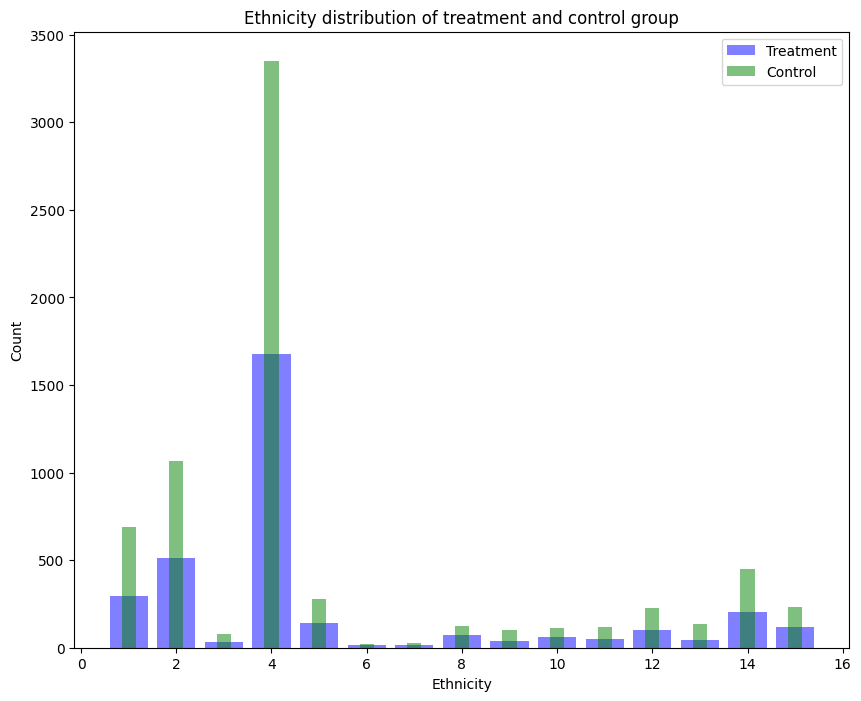

In [49]:
#we think that amongst the variables to cause inequality, ethnicity might be the most likely to cause an inequality
# Group by ethnicity
figure_d = plt.figure(figsize = (10,8))
treatment_ethnicity = df_realtime.groupby(['ethnicity','intervention']).size().reset_index(name='counts')
# Bar plot
plt.bar(treatment_ethnicity[treatment_ethnicity.intervention==1]['ethnicity'], treatment_ethnicity[treatment_ethnicity.intervention==1]['counts'], alpha = 0.5, label='Treatment', color = 'b')
plt.bar(treatment_ethnicity[treatment_ethnicity.intervention==0]['ethnicity'], treatment_ethnicity[treatment_ethnicity.intervention==0]['counts'], alpha = 0.5, label='Control', color = 'g', width = -.3)
plt.legend()
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Ethnicity distribution of treatment and control group')
plt.show()


In [50]:
df_realtime.groupby("ethnicity")["intervention"].mean()

ethnicity
1     0.299084
2     0.325095
3     0.292035
4     0.333996
5     0.340476
6     0.450000
7     0.395349
8     0.364103
9     0.266667
10    0.346591
11    0.305882
12    0.310769
13    0.247253
14    0.311350
15    0.335244
Name: intervention, dtype: float64

In [51]:
explanation_d = """
firstly we produced an analysis of the mean of the various ethnicities with regard to the intervention group.
there exists a possibility of an inequality which may overestimate the ATE. For ethnicity, the treatment variable is
measured by the student's ethnicity with regards to participation in the seminar. although the opportunity to participate
is random, participation is actually not because different ethnicities are under-represented here. Also, from the
visualization we can determine a selection bias between treated and controlled. We observe that less individuals from
specific ethnic groups were treated rather than it being a homogenous selection. for example for ethnic group 4.
a little over 50% of the control group not being treated. Even though situations like participant attrition may occur
this confounding occurence needs to be controlled.




"""